In [1]:
import pickle
import asyncio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from joblib import Parallel, delayed
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, mean_absolute_error

plt.style.use('ggplot')

In [2]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
print('\n'.join(color for color in colors))

#E24A33
#348ABD
#988ED5
#777777
#FBC15E
#8EBA42
#FFB5B8


In [3]:
def percent_scaling(series):
    return (series / 100)

def cpu_scaling(series):
    return (series * 4 / 100)

def single_cpu_scaling(series):
    return (((series - 100) * (-1)) / 100)

def min_max_scaling(series):
        return (series - series.min()) / (series.max() - series.min())

k = 251
latchup_start = 50000

In [4]:
def preprocess_df(df):
    df['cache_hit_rate_0'] = (df['cache_hit_0'] - df['cache_miss_0']) / df['cache_hit_0']
    df['cache_hit_rate_1'] = (df['cache_hit_0'] - df['cache_miss_1']) / df['cache_hit_1']
    df['cache_hit_rate_2'] = (df['cache_hit_0'] - df['cache_miss_2']) / df['cache_hit_2']
    df['cache_hit_rate_3'] = (df['cache_hit_0'] - df['cache_miss_3']) / df['cache_hit_3']
    
    df['br_miss_rate_0'] = df['br_miss_0'] / df['br_insns_0']
    df['br_miss_rate_1'] = df['br_miss_1'] / df['br_insns_1']
    df['br_miss_rate_2'] = df['br_miss_2'] / df['br_insns_2']
    df['br_miss_rate_3'] = df['br_miss_3'] / df['br_insns_3']
    
    df['insns_0_norm'] = df['insns_0'] / (df['time'] - df['time'].shift())
    df['insns_1_norm'] = df['insns_1'] / (df['time'] - df['time'].shift())
    df['insns_2_norm'] = df['insns_2'] / (df['time'] - df['time'].shift())
    df['insns_3_norm'] = df['insns_3'] / (df['time'] - df['time'].shift())
    
    df['cycles_0_norm'] = df['cpu_cycles_0'] / (df['time'] - df['time'].shift())
    df['cycles_1_norm'] = df['cpu_cycles_1'] / (df['time'] - df['time'].shift())
    df['cycles_2_norm'] = df['cpu_cycles_2'] / (df['time'] - df['time'].shift())
    df['cycles_3_norm'] = df['cpu_cycles_3'] / (df['time'] - df['time'].shift())
    
    df['bus_cycles_0_norm'] = df['bus_cycles_0'] / (df['time'] - df['time'].shift())
    df['bus_cycles_1_norm'] = df['bus_cycles_1'] / (df['time'] - df['time'].shift())
    df['bus_cycles_2_norm'] = df['bus_cycles_2'] / (df['time'] - df['time'].shift())
    df['bus_cycles_3_norm'] = df['bus_cycles_3'] / (df['time'] - df['time'].shift())

    df['rd_ios_norm'] = df['rd_ios'] * 1000 / (df['time'] - df['time'].shift())
    df['wr_ios_norm'] = df['wr_ios'] * 1000 / (df['time'] - df['time'].shift())

    df['curr_filt'] = df['current'].rolling(window=k, center=True, min_periods=1).min()
    
    df.drop(df.tail(k//2).index,inplace=True)
    df.drop(df.head(k//2).index,inplace=True)

    return df

In [5]:
def detect_latchup_diff(df, start):
    total_diff = 0
    count = 0
    end_time = latchup_df.loc[start, 'time'] + 5000000

    for row, entry in df.iterrows():
        if entry['time'] > end_time:
            break
        elif row > start:
            total_diff += entry['curr_filt'] - entry['curr_pred_min']
            count += 1

    return (total_diff/count > 0.055, total_diff, count)

In [6]:
idle_df = pd.read_csv('../results/disk-idle.csv')

idle_df = preprocess_df(idle_df)

X = idle_df[['insns_0_norm', 'insns_1_norm', 'insns_2_norm', 'insns_3_norm',
            'bus_cycles_0_norm', 'bus_cycles_1_norm', 'bus_cycles_2_norm', 'bus_cycles_3_norm',
            'br_miss_rate_0', 'br_miss_rate_1', 'br_miss_rate_2', 'br_miss_rate_3',
            'rd_ios_norm','wr_ios_norm',
            'freq_0', 'freq_1', 'freq_2', 'freq_3',
            'cache_hit_rate_0', 'cache_hit_rate_1', 'cache_hit_rate_2', 'cache_hit_rate_3']]
Y = idle_df['curr_filt']

idle_model = LinearRegression(n_jobs=8)
idle_model.fit(X, Y)

LinearRegression(n_jobs=8)

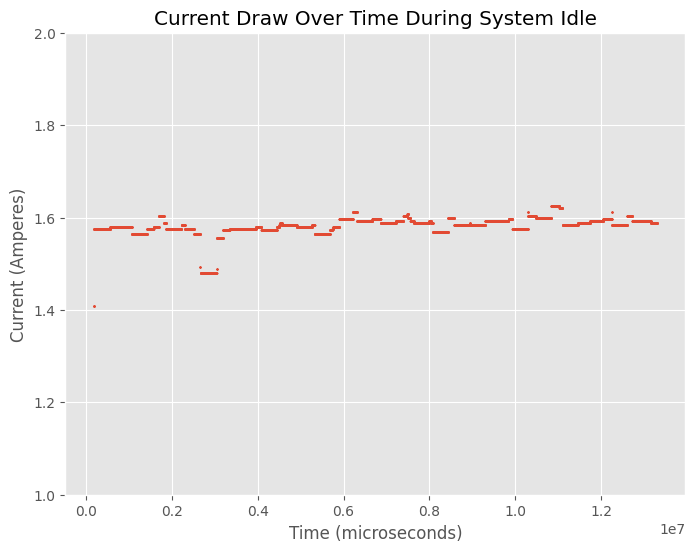

In [7]:
fig = plt.figure(figsize=(8, 6))
ax = plt.gca()

plt.scatter(idle_df['time'], idle_df['curr_filt'], label='actual', s=1)
plt.title('Current Draw Over Time During System Idle')
ax.set_ylim([1,2])
ax.set_xlabel("Time (microseconds)")
ax.set_ylabel("Current (Amperes)")

plt.savefig("sel_current_test.pdf", format="pdf", bbox_inches="tight")

In [8]:
latchup_df = pd.read_csv('../results/disk-idle-long.csv')
latchup_df.loc[latchup_start:,'current'] += 0.08

latchup_df = preprocess_df(latchup_df)

X_test = latchup_df[['insns_0_norm', 'insns_1_norm', 'insns_2_norm', 'insns_3_norm',
                     'bus_cycles_0_norm', 'bus_cycles_1_norm', 'bus_cycles_2_norm', 'bus_cycles_3_norm',
                     'br_miss_rate_0', 'br_miss_rate_1', 'br_miss_rate_2', 'br_miss_rate_3',
                     'rd_ios_norm','wr_ios_norm',
                     'freq_0', 'freq_1', 'freq_2', 'freq_3',
                     'cache_hit_rate_0', 'cache_hit_rate_1', 'cache_hit_rate_2', 'cache_hit_rate_3']]
Y_test = latchup_df['curr_filt']
latchup_df['curr_pred'] = idle_model.predict(X_test)

latchup_df['curr_pred_min'] = latchup_df['curr_pred'].rolling(window=k, center=True, min_periods=1).min()

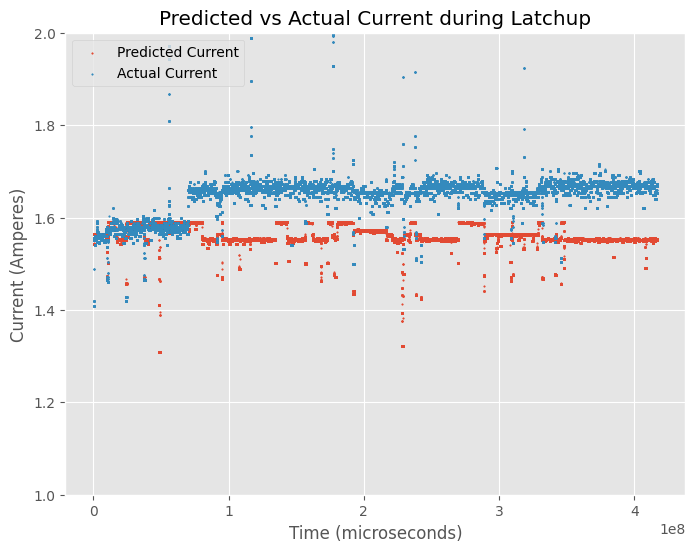

In [9]:
fig = plt.figure(figsize=(8, 6))
ax = plt.gca()

plt.scatter(latchup_df['time'], latchup_df['curr_pred_min'], label='predicted', s=1)
plt.scatter(latchup_df['time'], latchup_df['curr_filt'], label='actual', s=1)
plt.legend(['Predicted Current', 'Actual Current'], loc='upper left')
plt.title('Predicted vs Actual Current during Latchup')
ax.set_ylim([1,2])
ax.set_xlabel("Time (microseconds)")
ax.set_ylabel("Current (Amperes)")

plt.savefig("sel_current_latchup.pdf", format="pdf", bbox_inches="tight")

In [10]:
detect_latchup_diff(latchup_df, latchup_start)

(True, 221.541794511186, 3567)

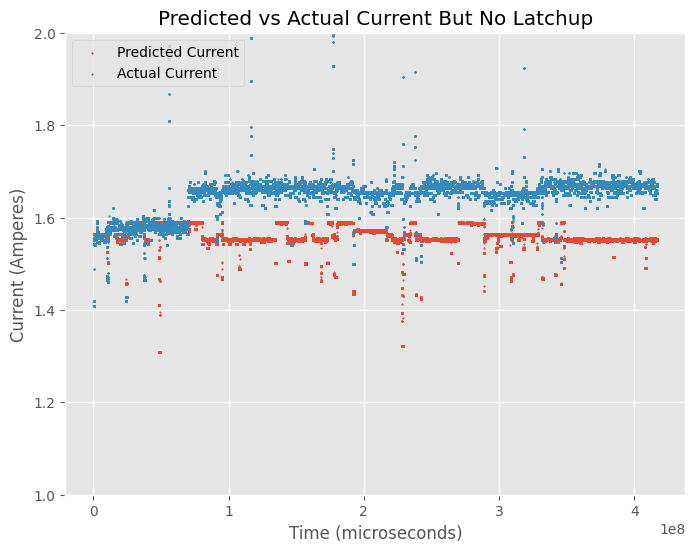

In [11]:
fig = plt.figure(figsize=(8, 6))
ax = plt.gca()

plt.scatter(latchup_df['time'], latchup_df['curr_pred_min'], label='predicted', s=1)
plt.scatter(latchup_df['time'], latchup_df['curr_filt'], label='actual', s=1)
plt.legend(['Predicted Current', 'Actual Current'], loc='upper left')
plt.title('Predicted vs Actual Current But No Latchup')
ax.set_ylim([1,2])
ax.set_xlabel("Time (microseconds)")
ax.set_ylabel("Current (Amperes)")

plt.savefig("sel_current_no_latchup.pdf", format="pdf", bbox_inches="tight")

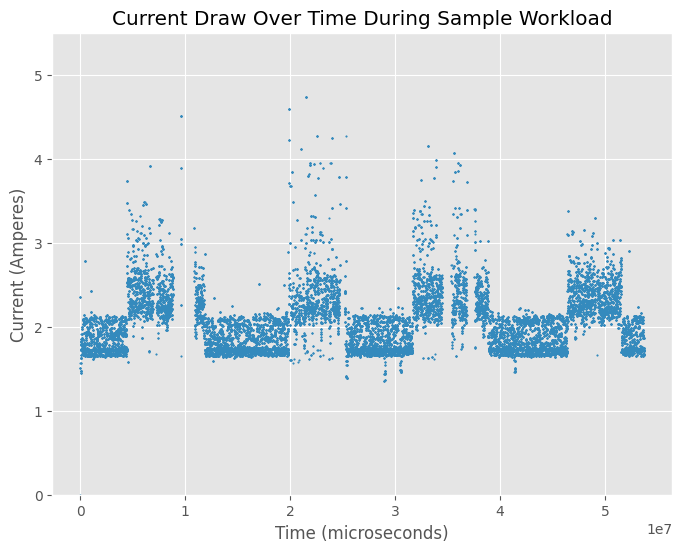

In [12]:
latchup_df = pd.read_csv('../results/disk-copy.csv')

fig = plt.figure(figsize=(8, 6))
ax = plt.gca()

plt.scatter(latchup_df['time'], latchup_df['current'], label='actual', s=1, color='#348ABD')
plt.title('Current Draw Over Time During Sample Workload')
ax.set_ylim([0, 5.5])
ax.set_xlabel("Time (microseconds)")
ax.set_ylabel("Current (Amperes)")

plt.savefig("sel_threshold_no_good_no_latchup.png", format="png", bbox_inches="tight")

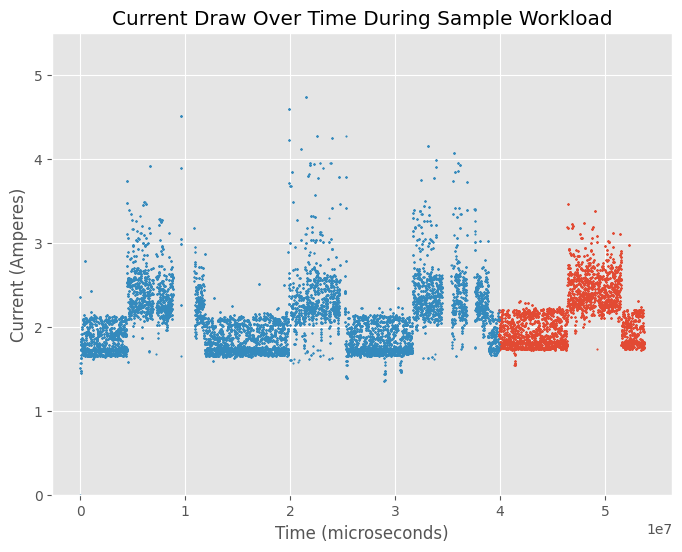

In [13]:
latchup_df = pd.read_csv('../results/disk-copy.csv')
latchup_df.loc[20000:,'current'] += 0.08

fig = plt.figure(figsize=(8, 6))
ax = plt.gca()

plt.scatter(latchup_df.loc[20000:,'time'], latchup_df.loc[20000:,'current'], label='actual', s=1)
plt.scatter(latchup_df.loc[:20000,'time'], latchup_df.loc[:20000,'current'], label='actual', s=1)
plt.title('Current Draw Over Time During Sample Workload')
ax.set_ylim([0, 5.5])
ax.set_xlabel("Time (microseconds)")
ax.set_ylabel("Current (Amperes)")

plt.savefig("sel_threshold_no_good_latchup.png", format="png", bbox_inches="tight")

In [95]:
latchup_df = pd.read_csv('../results/disk-idle-long.csv')

latchup_df = preprocess_df(latchup_df)

X_test = latchup_df[['insns_0_norm', 'insns_1_norm', 'insns_2_norm', 'insns_3_norm',
                     'bus_cycles_0_norm', 'bus_cycles_1_norm', 'bus_cycles_2_norm', 'bus_cycles_3_norm',
                     'br_miss_rate_0', 'br_miss_rate_1', 'br_miss_rate_2', 'br_miss_rate_3',
                     'rd_ios_norm','wr_ios_norm',
                     'freq_0', 'freq_1', 'freq_2', 'freq_3',
                     'cache_hit_rate_0', 'cache_hit_rate_1', 'cache_hit_rate_2', 'cache_hit_rate_3']]
Y_test = latchup_df['curr_filt']
latchup_df['curr_pred'] = idle_model.predict(X_test)

latchup_df['curr_pred_min'] = latchup_df['curr_pred'].rolling(window=k, center=True, min_periods=1).min()

In [98]:
count = 0

for curr in latchup_df['current']:
    if curr >= 1.75:
        count += 1

count / len(latchup_df)

0.4056348184740634

In [ ]:
def count_test(i):
    return detect_latchup_diff(latchup_df, i)

errs = Parallel(n_jobs=100)(delayed(count_test)(i) for i in range(1000, len(latchup_df), 300))

In [ ]:
len([i for i in errs if i[0]]) / len(errs)

In [ ]:
[i for i in errs if i[0]]

In [99]:
latchup_df = pd.read_csv('../results/disk-idle-long.csv')
latchup_df['current'] += 0.08

latchup_df = preprocess_df(latchup_df)

X_test = latchup_df[['insns_0_norm', 'insns_1_norm', 'insns_2_norm', 'insns_3_norm',
                     'bus_cycles_0_norm', 'bus_cycles_1_norm', 'bus_cycles_2_norm', 'bus_cycles_3_norm',
                     'br_miss_rate_0', 'br_miss_rate_1', 'br_miss_rate_2', 'br_miss_rate_3',
                     'rd_ios_norm','wr_ios_norm',
                     'freq_0', 'freq_1', 'freq_2', 'freq_3',
                     'cache_hit_rate_0', 'cache_hit_rate_1', 'cache_hit_rate_2', 'cache_hit_rate_3']]
Y_test = latchup_df['curr_filt']
latchup_df['curr_pred'] = idle_model.predict(X_test)

latchup_df['curr_pred_min'] = latchup_df['curr_pred'].rolling(window=k, center=True, min_periods=1).min()

In [100]:
count = 0

for curr in latchup_df['current']:
    if curr >= 1.85:
        count += 1

(len(latchup_df) - count) / len(latchup_df)

0.6212486773913102

In [ ]:
errs = Parallel(n_jobs=100)(delayed(count_test)(i) for i in range(1000, len(latchup_df), 300))

len([i for i in errs if i[0]]) / len(errs)

In [ ]:
[i for i in errs if i[0] != True]